In [1]:
#import streamlit as st
import pandas as pd
import geopandas as gpd
import leafmap.colormaps as cm
import pydeck as pdk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import contextily as cx

## CHECK THE CRS!!!

In [2]:
#Inspiration from https://towardsdatascience.com/from-kernel-density-estimation-to-spatial-analysis-in-python-64ddcdb6bc9b

In [3]:
from shapely.geometry import Polygon, MultiPolygon

In [4]:
from matplotlib.patches import Rectangle

from leafmap.common import hex_to_rgb
#from dawa_scrape_prod import DAWA_data

from shapely.geometry import Point
from shapely.ops import nearest_points

In [5]:
pd.set_option('display.max_columns', 500)

In [6]:
plt.rcParams.update({
    #"figure.facecolor":  (1.0, 0.0, 0.0, 0.3),  # red   with alpha = 30%
    #"axes.facecolor":    (0.0, 1.0, 0.0, 0.5),  # green with alpha = 50%
    "savefig.facecolor": (0.0, 0.0, 0.0, 0),  # blue  with alpha = 20%
})

COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

def custom_round(x, base=5):
    return int(round(float(x*100)/base))

#@st.cache(allow_output_mutation=True)
def get_data(limit=None):
    #read scraped data in
    #df = pd.read_csv('data/final_final_data.csv', sep=';').drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
    gdf = gpd.read_file('data/final_geodataframe_v2.geojson')

    if limit:
        gdf = gdf.head(limit)

    #convert adjusted_sqm_price to thousand separated integer (string)
    gdf['tooltip_price'] = gdf['adjusted_sqm_price'].astype(int)
    gdf['tooltip_price'] = gdf['tooltip_price'].map('{:,.2f}'.format)

    #strip apartment identifier and store just address for tooltip
    gdf['tooltip_address'] = [a.strip().split(',')[0] for a in gdf['address'].values.tolist()]

    #scale price to get elevation right for plot
    gdf['scaled_adjusted_sqm_price']=(gdf['adjusted_sqm_price']-gdf['adjusted_sqm_price'].min())/(gdf['adjusted_sqm_price'].max()-gdf['adjusted_sqm_price'].min())

    gdf['color_int'] = gdf['scaled_adjusted_sqm_price'].apply(lambda x: custom_round(x,base=5))
    return gdf

#@st.cache
def get_postnumre():
    gdf = gpd.read_file('data/filtered_postnumre.geojson')
    return gdf

#@st.cache
def get_sogne():
    gdf = gpd.read_file('data/sogne.geojson')
    return gdf


def pd_column_to_pretty(pd_column):
    d = {'square_meters_price':'Price m\u00b2',
        'adjusted_sqm_price': 'Adj. price m\u00b2'
    }
    return d[pd_column]


In [7]:
#gdf = get_data(limit=5000)
gdf = get_data()

In [8]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
if False:
    sns.kdeplot(
        gdf["lng"], 
        gdf["lat"], 
        n_levels=50, 
        shade=True, 
        cmap='BuPu'
    );

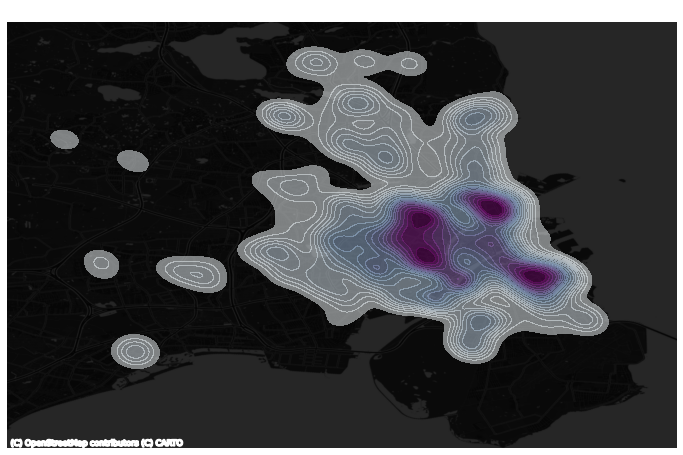

In [39]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(12, 12))
# Add KDE layer that displays probability surface
sns.kdeplot(
    gdf["lng"], 
    gdf["lat"], 
    n_levels=20, 
    shade=True, 
    cmap='BuPu',
    alpha = 0.5
)

# Remove axis
ax.set_axis_off()
# Add basemap
cx.add_basemap(
    ax, 
    crs= "EPSG:4326",
    source=cx.providers.CartoDB.DarkMatterNoLabels
)
# Add title of the map
ax.set_title("Kernel Density Estimation of appartment data in Copenhagen")
# Draw map
plt.show()

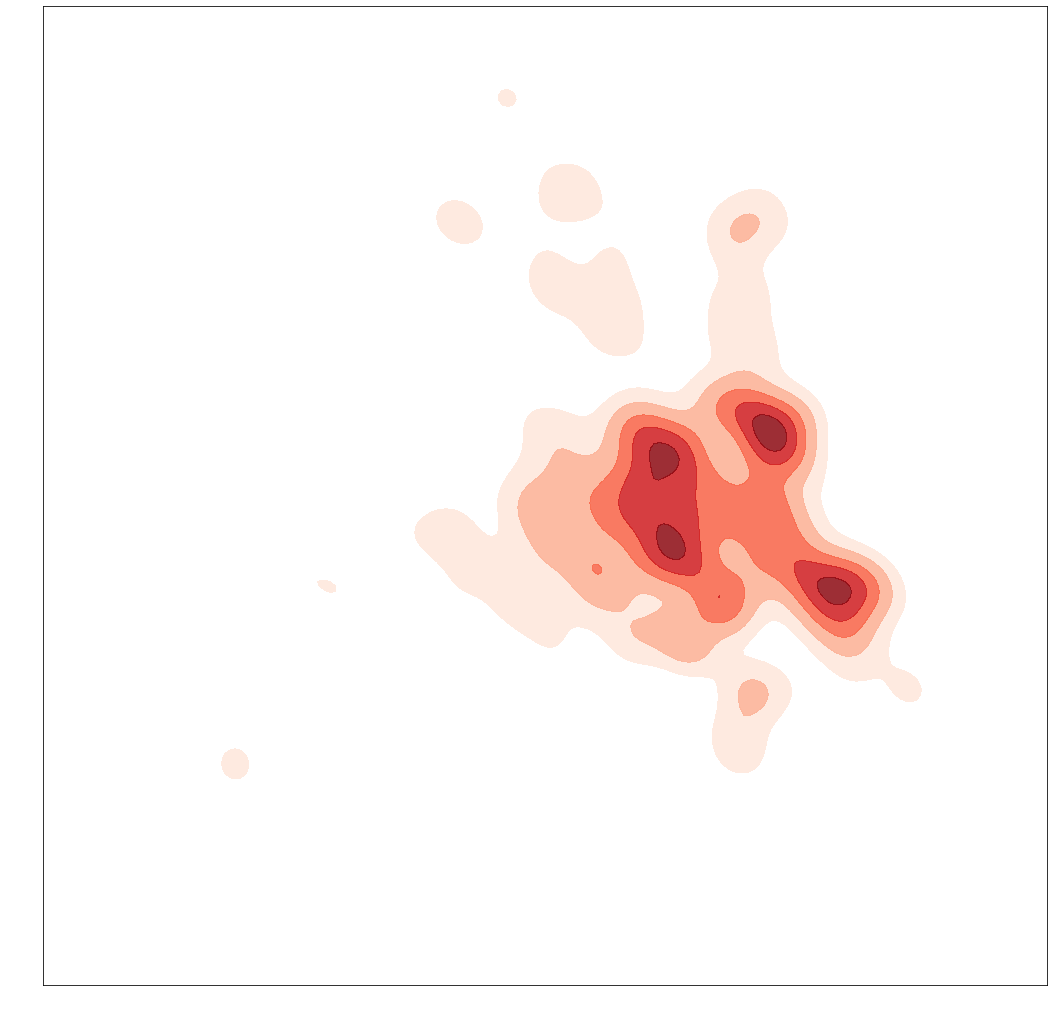

In [11]:
levels = [0.2,0.4,0.6,0.8,0.95,1]

# Setup figure and axis
f, ax = plt.subplots(1, figsize=(18, 18))
# Add KDE layer that displays probability surface

kde = sns.kdeplot(
    ax=ax,
    x=gdf['geometry'].x,
    y= gdf['geometry'].y,
    levels = levels,
    shade=True,
    cmap='Reds',
    alpha=0.85
)

# Remove axis
#ax.set_axis_off()
# Add basemap
#cx.add_basemap(
#    ax, 
#    crs= gdf.crs.to_string(),
#    source=cx.providers.CartoDB.DarkMatterNoLabels
#)
# Add title of the map
#ax.set_title("Kernel Density Estimation of appartment data in Copenhagen")
# Save as file
#plt.savefig('density_plot.png', dpi=200)
# Draw map
#plt.show()

In [12]:
level_polygons = []
i = 0
for col in kde.collections:
    paths = []
    # Loop through all polygons that have the same intensity level
    for contour in col.get_paths(): 
        # Create a polygon for the countour
        # First polygon is the main countour, the rest are holes
        for ncp,cp in enumerate(contour.to_polygons()):
            x = cp[:,0]
            y = cp[:,1]
            new_shape = Polygon([(i[0], i[1]) for i in zip(x,y)])
            if ncp == 0:
                poly = new_shape
            else:
                # Remove holes, if any
                poly = poly.difference(new_shape)

        # Append polygon to list
        paths.append(poly)
    # Create a MultiPolygon for the contour
    multi = MultiPolygon(paths)
    # Append MultiPolygon and level as tuple to list
    level_polygons.append((levels[i], multi))
    i+=1

In [13]:
# Create DataFrame
df = pd.DataFrame(level_polygons, columns =['level', 'geometry'])
# Convert to a GeoDataFrame
geo = gpd.GeoDataFrame(df, geometry='geometry', crs = gdf.crs)
# Set CRS for geometric operations
geo = geo.to_crs(gdf.crs.to_string())
# Calculate area
geo['area'] = geo['geometry'].area
# Save to file
#geo.to_file('geo_file.gpkg', driver='GPKG')

In [14]:
#sort acording to level, descending
geo = geo.sort_values('level', ascending=False).reset_index(drop=True)
geo

,level,geometry,area
0,0.95,"MULTIPOLYGON (((12.60990 55.65794, 12.61199 55...",0.000356
1,0.80,"MULTIPOLYGON (((12.61317 55.65310, 12.61199 55...",0.001270
2,0.60,"MULTIPOLYGON (((12.60880 55.65045, 12.60781 55...",0.002334
3,0.40,"MULTIPOLYGON (((12.57436 55.62744, 12.57645 55...",0.003456
4,0.20,"MULTIPOLYGON (((12.36320 55.61044, 12.36529 55...",0.007010


In [15]:
apartments = gdf.geometry.tolist()

sales_density_levels = geo['level'].tolist()
sales_density_geometry = geo.geometry.tolist()

sales_density_score = []
for a in apartments:
    for idx, level in enumerate(sales_density_geometry):
        found = False
        if a.intersects(level):
            #print(idx)
            sales_density_score.append(sales_density_levels[idx])
            found = True
            break
    if not found:
        sales_density_score.append(0)

gdf['kde_sales_density'] = sales_density_score

In [16]:
gdf[['address','city','scaled_adjusted_sqm_price','kde_sales_density']]

,address,city,scaled_adjusted_sqm_price,kde_sales_density
0,"Brøndbyvestervej 36, 1. th",Brøndby,0.066044,0.0
1,Sortemosevej 130,Herlev,0.109191,0.0
2,Kamdalen 18A,Herlev,0.079320,0.0
3,"Klokkedybet 3, st. c",Herlev,0.060428,0.0
4,"Fagotvej 14, st. tv",Herlev,0.066877,0.0
...,...,...,...,...
71561,"Bolystvej 1F, 1. th",Hvidovre,0.081352,0.2
71562,Baunebakkevej 9,Hvidovre,0.110412,0.2
71563,"Rebæk Søpark 21, 6. mf",Hvidovre,0.060594,0.0
71564,"Gammel Køge Landevej 220B, 2. mf",Hvidovre,0.034976,0.0


# Amenity Density

In [12]:
OSM_filtered = gpd.read_file('data/osm_filtered.geojson')

In [13]:
types = set(OSM_filtered['type'].tolist())

In [14]:
OSM_filtered['point'] = OSM_filtered.geometry.centroid

In [29]:
for t in sorted(types):
    if t == 'grocery':
        continue
    OSM_type_filtered = OSM_filtered[OSM_filtered['type'] == t]
    print(t,len(OSM_type_filtered))

bar 557
cafe 1224
coastline 112
college 30
kindergarten 289
restaurant 911
school 318
supermarket 562
university 35
water 157


In [15]:
cmap = sns.cubehelix_palette(start=.5,rot=-.75, as_cmap=True,reverse=True)

bar


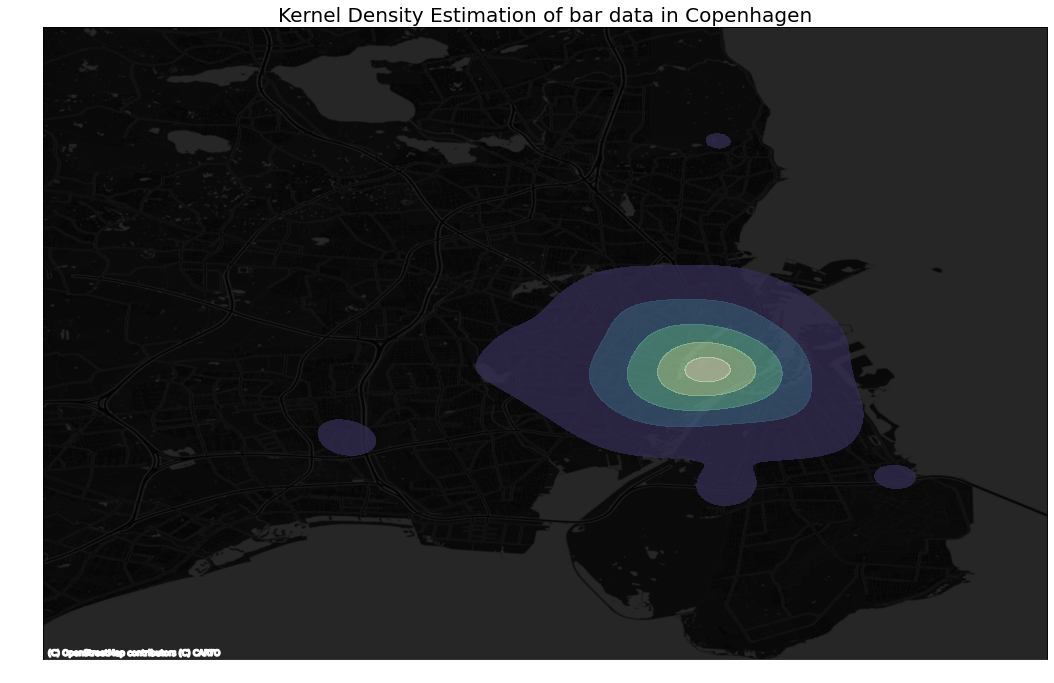

cafe


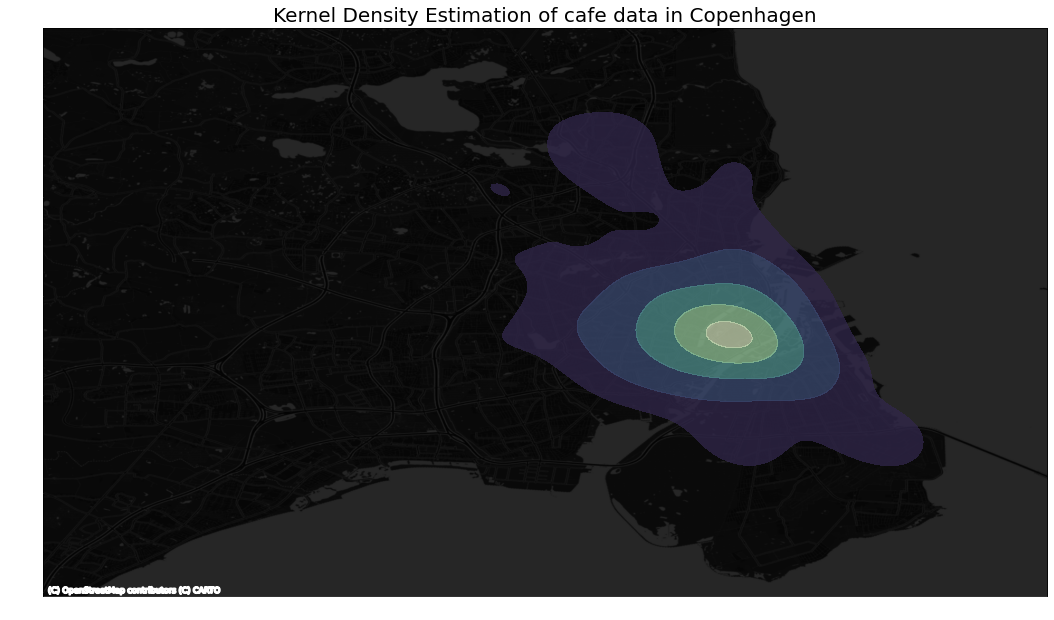

college


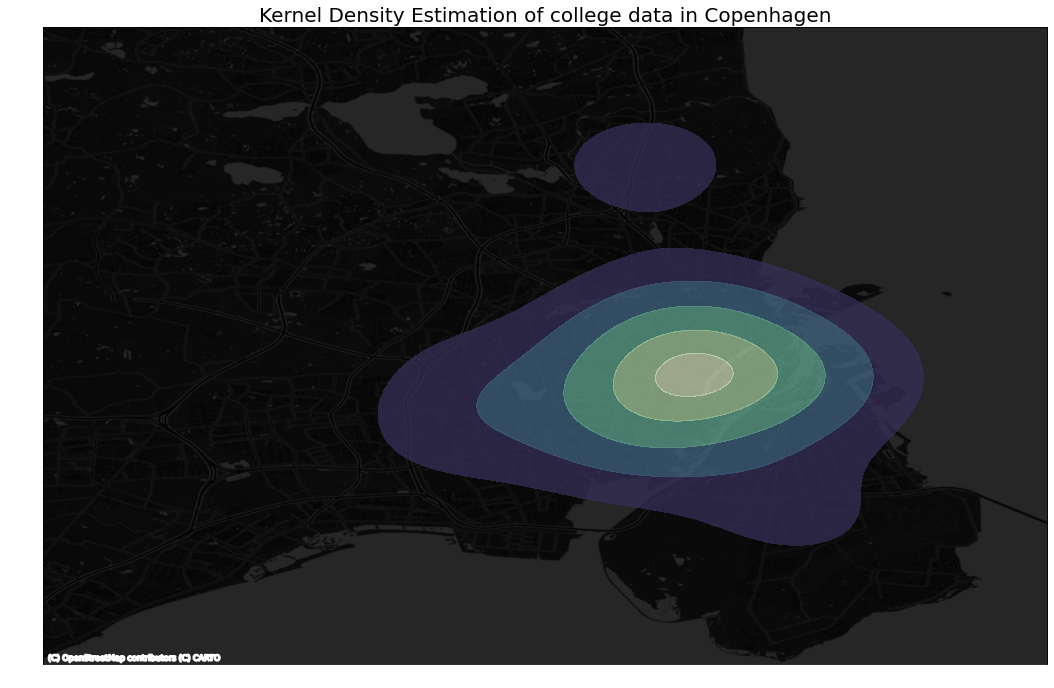

kindergarten


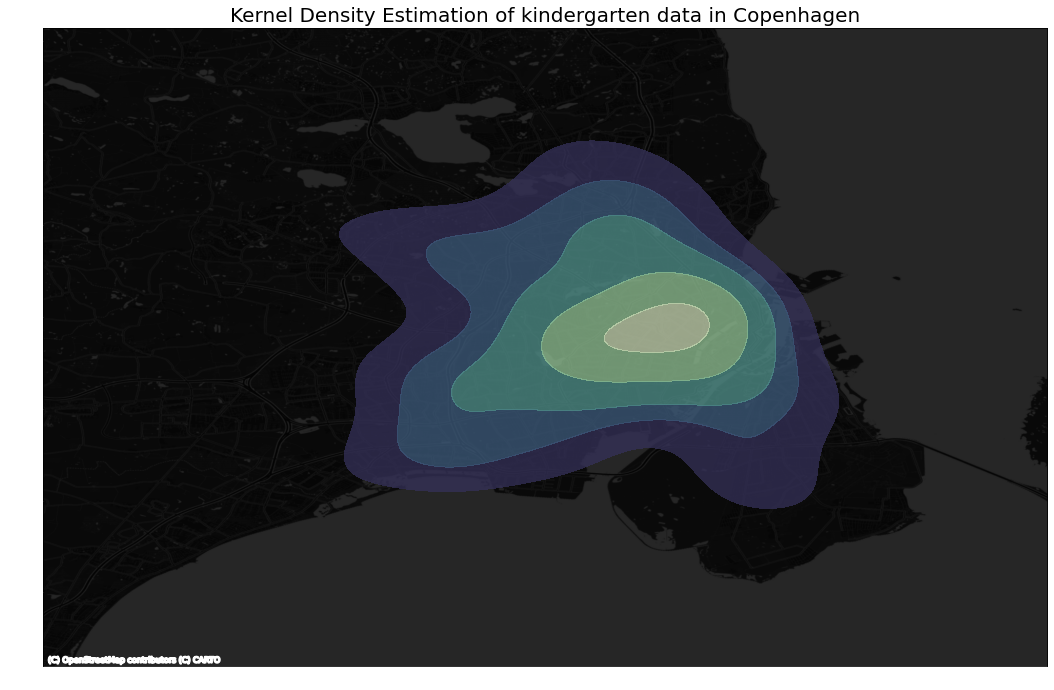

restaurant


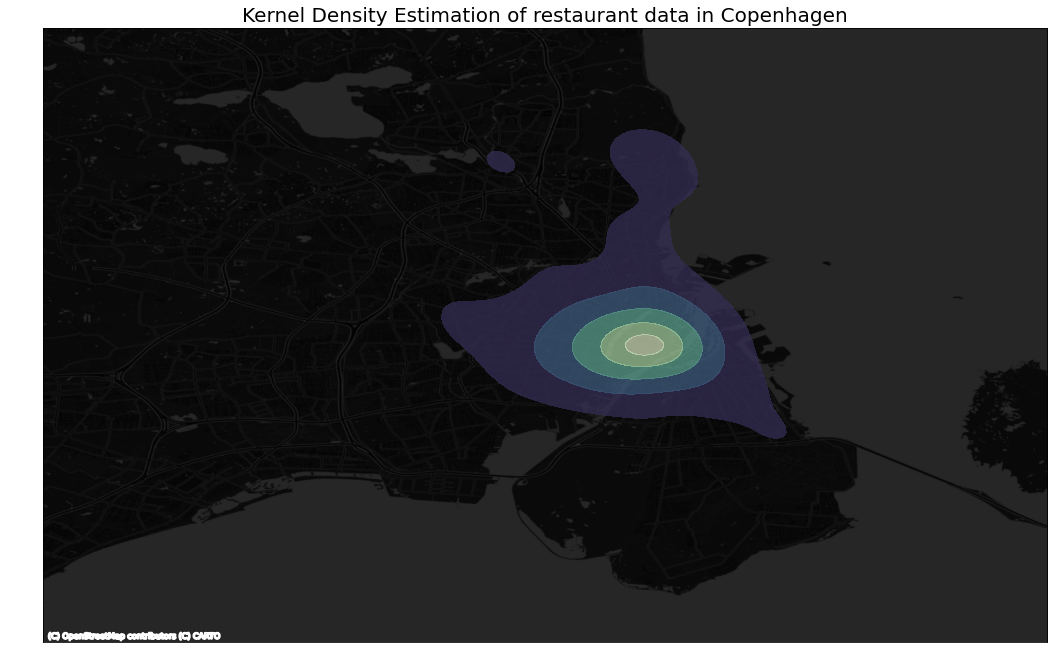

school


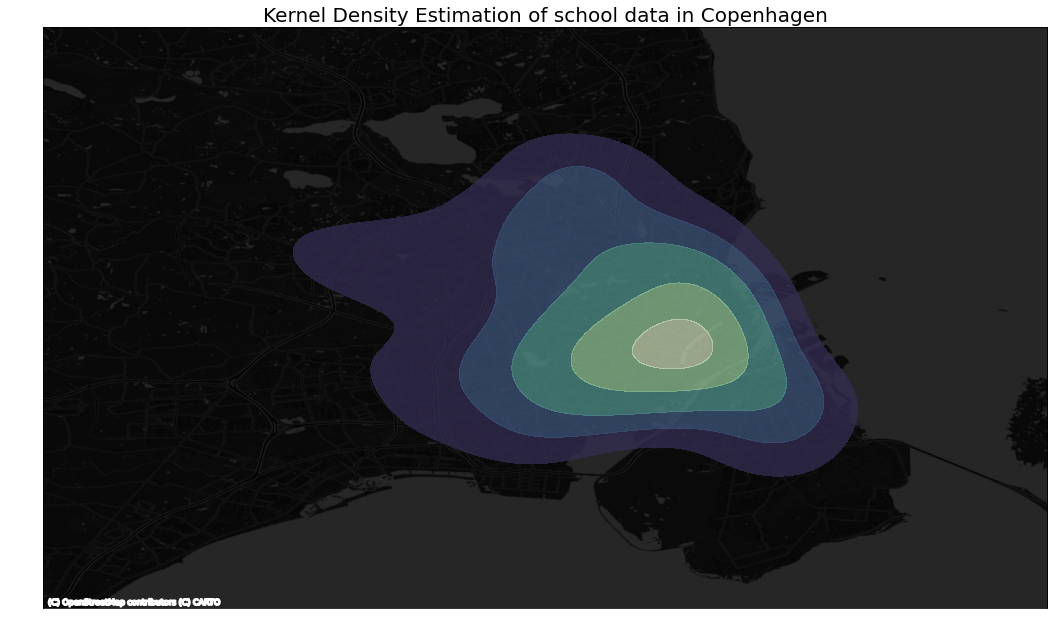

supermarket


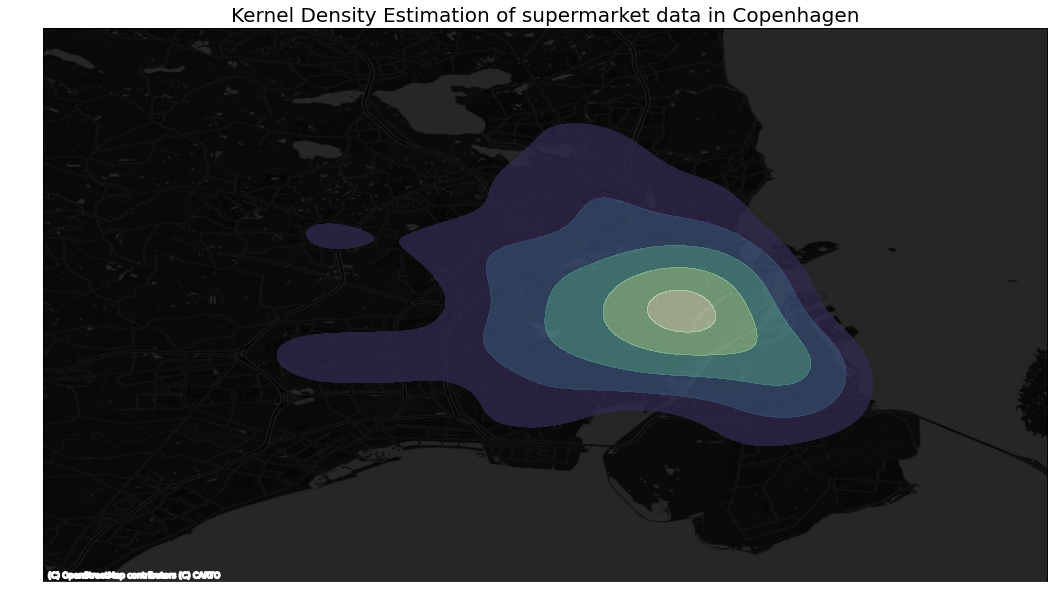

university


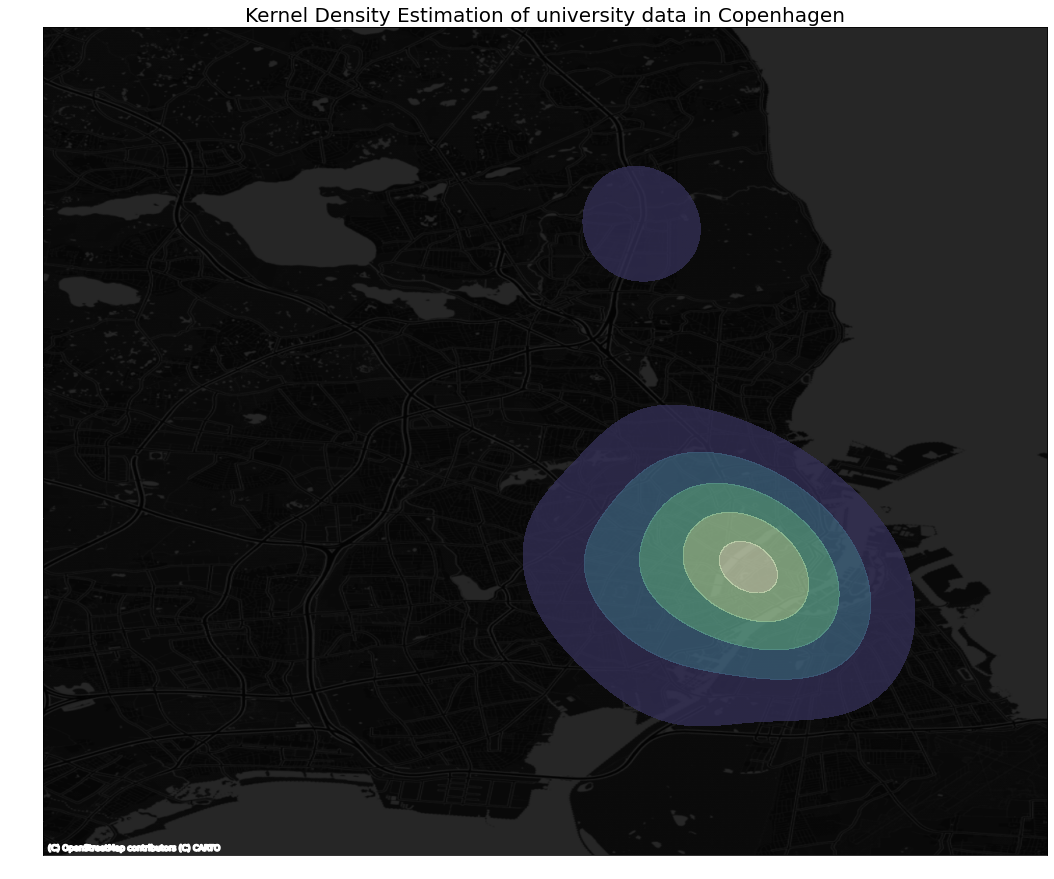

In [16]:
for t in sorted(types):
    if t in ['grocery','coastline','water']:
        continue
    
    print(t)
    
    OSM_type_filtered = OSM_filtered[OSM_filtered['type'] == t]
        
    levels = [0.2,0.4,0.6,0.8,0.95,1]
    

    # Setup figure and axis
    f, ax = plt.subplots(1, figsize=(18, 18))
    # Add KDE layer that displays probability surface

    kde = sns.kdeplot(
        ax=ax,
        x=OSM_type_filtered['point'].x,
        y= OSM_type_filtered['point'].y,
        levels = levels,
        shade=True,
        cmap=cmap,
        alpha=0.75,
    )  
    
    cx.add_basemap(
    ax, 
    #crs= "EPSG:4326",
    crs = OSM_type_filtered.crs,
    source=cx.providers.CartoDB.DarkMatterNoLabels
    )
    
    # Add title of the map
    plt.title("Kernel Density Estimation of " + t+ " data in Copenhagen",color='black',fontsize=20)
    # Draw map
    plt.show()
    
    
    level_polygons = []
    i = 0
    for col in kde.collections:
        paths = []
        # Loop through all polygons that have the same intensity level
        for contour in col.get_paths(): 
            # Create a polygon for the countour
            # First polygon is the main countour, the rest are holes
            for ncp,cp in enumerate(contour.to_polygons()):
                x = cp[:,0]
                y = cp[:,1]
                new_shape = Polygon([(i[0], i[1]) for i in zip(x,y)])
                if ncp == 0:
                    poly = new_shape
                else:
                    # Remove holes, if any
                    poly = poly.difference(new_shape)

            # Append polygon to list
            paths.append(poly)
        # Create a MultiPolygon for the contour
        multi = MultiPolygon(paths)
        # Append MultiPolygon and level as tuple to list
        level_polygons.append((levels[i], multi))
        i+=1

    # Create DataFrame
    df = pd.DataFrame(level_polygons, columns =['level', 'geometry'])
    # Convert to a GeoDataFrame
    geo = gpd.GeoDataFrame(df, geometry='geometry', crs = gdf.crs)
    # Set CRS for geometric operations
    geo = geo.to_crs(gdf.crs.to_string())
    # Calculate area
    geo['area'] = geo['geometry'].area
    # Save to file
    #geo.to_file('geo_file.gpkg', driver='GPKG')
    
    apartments = gdf.geometry.tolist()

    density_levels = geo['level'].tolist()
    density_geometry = geo.geometry.tolist()

    density_score = []
    
    for a in apartments:
        for idx, level in enumerate(density_geometry):
            found = False
            if a.intersects(level):
                #print(idx)
                density_score.append(density_levels[idx])
                found = True
                break
        if not found:
            density_score.append(0)

    string ='kde_'+ t + '_density' 
    gdf[string] = density_score

In [40]:
gdf.head()

,address,address_url,adjusted_sqm_price,air,city,energy,factor,faulty,final_url,id,idx,kommune,lat,latest_sale_date,latest_sale_price,lng,min_dist_to_bar,min_dist_to_cafe,min_dist_to_coastline,min_dist_to_college,min_dist_to_grocery,min_dist_to_kindergarten,min_dist_to_restaurant,min_dist_to_school,min_dist_to_supermarket,min_dist_to_university,min_dist_to_water,noise,postal,sognekode,square_meters,square_meters_price,tmp_address,year,geometry,tooltip_price,tooltip_address,scaled_adjusted_sqm_price,color_int,kde_sales_density,kde_bar_density,kde_cafe_density,kde_college_density,kde_kindergarten_density,kde_restaurant_density,kde_school_density,kde_supermarket_density,kde_university_density
0,"Brøndbyvestervej 36, 1. th",2605-brøndby,28670.886076,"[12.0, 10.0, 15.8, 0.4]",Brøndby,D,1.0,False,https://www.dingeo.dk/adresse/2605-br%C3%B8ndb...,0,0,brøndby,55.658384,09-02-2022,2265000,12.408499,951.662301,566.024918,5059.015726,1985.624169,1868.263978,337.118558,827.322936,611.867063,516.251242,3699.926755,573.555232,55-60,2605,7147,79,28670.886076,brøndbyvestervej-36/1-th,2022,POINT (12.40850 55.65838),"28,670.00",Brøndbyvestervej 36,0.066044,1,0.0,0.0,0.0,0.0,0.4,0.0,0.2,0.2,0.0
1,Sortemosevej 130,2730-herlev,44070.000000,"[13.0, 10.6, 16.8, 0.4]",Herlev,C,1.0,False,https://www.dingeo.dk/adresse/2730-herlev/sort...,1,244,herlev,55.758909,16-11-2022,4407000,12.395060,2783.124323,2063.646349,12027.545730,2580.967833,6725.606020,868.066449,1937.154057,507.718033,1109.395972,2921.605882,616.376298,< 55,2730,9074,100,44070.000000,sortemosevej-130,2022,POINT (12.39506 55.75891),"44,070.00",Sortemosevej 130,0.109191,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Kamdalen 18A,2730-herlev,33409.090909,"[13.0, 10.3, 16.1, 0.4]",Herlev,E,1.0,False,https://www.dingeo.dk/adresse/2730-herlev/kamd...,2,245,herlev,55.735734,16-02-2022,3675000,12.415977,1143.043405,1076.098845,10238.993842,1977.064923,5766.517689,344.107553,908.918135,508.933440,280.160789,1094.954178,508.376298,< 55,2730,9074,110,33409.090909,kamdalen-18a,2022,POINT (12.41598 55.73573),"33,409.00",Kamdalen 18A,0.079320,2,0.0,0.0,0.0,0.0,0.4,0.0,0.2,0.0,0.0
3,"Klokkedybet 3, st. c",2730-herlev,26666.666667,"[14.0, 10.2, 16.1, 0.4]",Herlev,E,1.0,False,https://www.dingeo.dk/adresse/2730-herlev/klok...,3,246,herlev,55.717491,21-01-2022,960000,12.457055,878.682142,483.561380,7639.096233,3536.032897,3598.617508,213.749985,436.992813,834.243721,526.458541,3818.318751,460.504329,65-70,2730,7136,36,26666.666667,klokkedybet-3/st-c,2022,POINT (12.45706 55.71749),"26,666.00",Klokkedybet 3,0.060428,1,0.0,0.0,0.0,0.0,0.4,0.0,0.4,0.4,0.0
4,"Fagotvej 14, st. tv",2730-herlev,28968.253968,"[22.0, 11.4, 19.3, 0.6]",Herlev,D,1.0,False,https://www.dingeo.dk/adresse/2730-herlev/fago...,4,247,herlev,55.717952,13-01-2022,1825000,12.440005,827.421658,502.252896,8700.101802,3717.228494,3539.972696,223.871353,654.424352,662.650879,135.198401,2830.342305,958.522058,55-60,2730,7136,63,28968.253968,fagotvej-14/st-tv,2022,POINT (12.44000 55.71795),"28,968.00",Fagotvej 14,0.066877,1,0.0,0.0,0.0,0.0,0.4,0.0,0.2,0.2,0.0


In [17]:
gdf.kde_kindergarten_density.value_counts()

0.80    18992
0.60    17702
0.40    10895
0.20    10341
0.95     8709
0.00     4927
Name: kde_kindergarten_density, dtype: int64

In [18]:
! ls data/

filtered_postnumre.geojson    postnumre_filtered_v2.geojson
final_geodataframe_v2.geojson sogne.geojson
osm_filtered.geojson


In [28]:
gdf_1, gdf_2 = np.array_split(gdf,2)

In [29]:
type(gdf_2)

geopandas.geodataframe.GeoDataFrame

In [32]:
with open('data/final_geodataframe_v3_1.geojson', 'w') as out:
    out.write(gdf_1.to_json())
    
with open('data/final_geodataframe_v3_2.geojson', 'w') as out:
    out.write(gdf_2.to_json())

In [31]:
! ls data/

filtered_postnumre.geojson      final_geodataframe_v3_2.geojson
final_geodataframe_v2.geojson   osm_filtered.geojson
final_geodataframe_v3.geojson   postnumre_filtered_v2.geojson
final_geodataframe_v3_1.geojson sogne.geojson


# Correlations

In [88]:
from scipy.stats import pearsonr

In [90]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [62]:
#df['A'].corr(df['B'])
min_dist_columns = [x for x in gdf.columns.tolist() if '_dist_to' in x]
density_columns = [x for x in gdf.columns.tolist() if 'kde_' in x]

In [93]:
gdf_scaled = pd.DataFrame(scaler.fit_transform(gdf[min_dist_columns]), columns=min_dist_columns)

In [95]:
min_dist_correlations = {}
for column in min_dist_columns:
    min_dist_correlations[column] = pearsonr(gdf['scaled_adjusted_sqm_price'],gdf_scaled[column])

In [86]:
density_correlations = {}
for column in density_columns:
    density_correlations[column] = pearsonr(gdf['scaled_adjusted_sqm_price'],gdf[column])

In [96]:
for k in sorted(min_dist_correlations, key=min_dist_correlations.get, reverse=True):
    print(k,'\t' ,min_dist_correlations[k])

min_dist_to_kindergarten 	 (0.14699791594558972, 0.0)
min_dist_to_school 	 (0.02212126894956585, 3.2496336636807464e-09)
min_dist_to_water 	 (-0.022171366537441502, 2.995035798509506e-09)
min_dist_to_supermarket 	 (-0.040596602486249904, 1.6992931174996275e-27)
min_dist_to_bar 	 (-0.11776297188240681, 2.428435231876904e-219)
min_dist_to_grocery 	 (-0.21672673194471018, 0.0)
min_dist_to_college 	 (-0.22395248230808124, 0.0)
min_dist_to_restaurant 	 (-0.31049046530063595, 0.0)
min_dist_to_cafe 	 (-0.32761321756590595, 0.0)
min_dist_to_university 	 (-0.34837407086057703, 0.0)
min_dist_to_coastline 	 (-0.43715826080241776, 0.0)


In [88]:
for k in sorted(density_correlations, key=density_correlations.get, reverse=True):
    print(k,'\t' ,density_correlations[k])

kde_restaurant_density 	 (0.4975272664604219, 0.0)
kde_cafe_density 	 (0.48765574671764617, 0.0)
kde_bar_density 	 (0.45036508364299244, 0.0)
kde_university_density 	 (0.43579098681975836, 0.0)
kde_college_density 	 (0.4086952401781566, 0.0)
kde_sales_density 	 (0.3673659635001687, 0.0)
kde_school_density 	 (0.34509856411174533, 0.0)
kde_supermarket_density 	 (0.33335314261719085, 0.0)
kde_kindergarten_density 	 (0.21234067928273312, 0.0)


In [110]:
min_dist_columns

['min_dist_to_bar',
 'min_dist_to_cafe',
 'min_dist_to_coastline',
 'min_dist_to_college',
 'min_dist_to_grocery',
 'min_dist_to_kindergarten',
 'min_dist_to_restaurant',
 'min_dist_to_school',
 'min_dist_to_supermarket',
 'min_dist_to_university',
 'min_dist_to_water']

# Air pollution Analysis

In [48]:
#explode 'air' column into lists of four integers
new_columns = [[float(x) if x != 'None' else None for x in x.strip(' []').split(', ')] for x in gdf['air'].tolist()]

In [51]:
#store in individual columns
gdf['NO_2'] = [x[0] for x in new_columns]
gdf['PM2_5'] = [x[1] for x in new_columns]
gdf['PM_10'] = [x[2] for x in new_columns]
gdf['black_carbon'] = [x[3] for x in new_columns]

In [91]:
#store names of columns
air_columns = ['NO_2','PM2_5','PM_10','black_carbon']

#drop na for correlation
new_gdf = gdf.dropna()

#dict to keep the scores and significances
air_correlations = {}

#loop through columns
for column in air_columns:
    #correlate with price
    air_correlations[column] = pearsonr(new_gdf['scaled_adjusted_sqm_price'],new_gdf[column])

In [92]:
for k in sorted(air_correlations, key=air_correlations.get, reverse=True):
    print(k,'\t' ,air_correlations[k])

black_carbon 	 (0.08004328634584458, 9.302407325233281e-98)
PM2_5 	 (0.01433132600938368, 0.00017604077157541437)
PM_10 	 (0.006554630647669794, 0.08624246881660123)
NO_2 	 (0.0020493793052154615, 0.5916930177224702)
